# SABR Model

* [1. Introduction](#1)
* [2. Dynamics modelization](#2)
* [3. Calibration on a specific maturity](#3)
    * [3.1 Getting Data from yfinance](#3.1)
    * [3.2 Hagan's approximation of Implied Volatility](#3.2)
    * [3.3 MSE Calibration](#3.3)
* [4. Surface Calibration](#4)
    * [4.1 Getting Data from yfinance](#4.1)
    * [4.2 Global Calibration](#4.2)
    * [4.3 Maturity-by-maturity calibration](#4.3)
* [5. Example use: Terminal density of the stock Price](#5)
    * [5.1 using a global fit](#5.1)
    * [5.1 using a maturity-by-maturity fit](#5.1)
* [6. Conclusion](#6)    

<a id='1' > </a>
# <u>1.Introduction

The **SABR (Stochastic Alpha Beta Rho)** model is a stochastic volatility model widely used for modeling the dynamics of implied volatility in derivative markets. It is especially popular in interest rate and foreign exchange markets.

### Model Dynamics

The SABR model assumes that the underlying forward price $ F_t $ and its volatility $ \sigma_t $ evolve according to the following stochastic differential equations (SDEs):

$$
\begin{aligned}
dF_t &= \sigma_t F_t^\beta \, dW_t, \\
d\sigma_t &= \nu\, \sigma_t \, dZ_t,
\end{aligned}
$$

where:
- $ F_t $ is the forward price,
- $ \sigma_t $ is the instantaneous volatility,
- $ \beta \in [0,1] $ controls the elasticity of the underlying (with $\beta = 1$ corresponding to a lognormal model and $\beta = 0$ to a normal model),
- $ \nu $ is the volatility of volatility,
- $ W_t $ and $ Z_t $ are two correlated Brownian motions with correlation coefficient $ \rho $:
  
$$
dW_t\, dZ_t = \rho\, dt.
$$

### Hagan's Asymptotic Formula for Implied Volatility

An asymptotic expansion for the implied volatility under the SABR model was derived by Hagan et al. The approximate implied volatility $ \sigma_{\text{imp}}(K) $ for an option with strike $ K $ and time-to-maturity $ T $ is given by:

$$
\sigma_{\text{imp}}(K) = \frac{\alpha}{(F K)^{\frac{1-\beta}{2}}} \frac{z}{x(z)} \left\{ 1 + \left[ \frac{(1-\beta)^2}{24} \frac{\log^2\left(\frac{F}{K}\right)}{(F K)^{1-\beta}} + \frac{\rho \beta \nu\, \log\left(\frac{F}{K}\right)}{4 (F K)^{\frac{1-\beta}{2}}} + \frac{\nu^2 (2-3\rho^2)}{24} \right] T \right\},
$$

where:
- $ \alpha $ is the initial volatility (i.e., $ \sigma_0 $),
- $ z $ is defined as:

$$
z = \frac{\nu}{\alpha} (F K)^{\frac{1-\beta}{2}} \log\left(\frac{F}{K}\right),
$$

- $ x(z) $ is given by:

$$
x(z) = \log\left(\frac{\sqrt{1 - 2\rho z + z^2} + z - \rho}{1 - \rho}\right).
$$

In the special case where $ F = K $ (the at-the-money case), the formula simplifies significantly.

### Key Parameters Recap

- **$ \alpha $**: Initial volatility level.
- **$ \beta $**: Controls the dependence of volatility on the level of the forward price.  
- **$ \nu $**: Volatility of volatility (how volatile the volatility is).
- **$ \rho$**: Correlation between the underlying asset and its volatility.

### Applications

- **Calibration**: The SABR model is calibrated by choosing the parameters $\alpha$, $\beta$, $\nu$, and $\rho$ so that the model-implied volatilities match market-observed implied volatilities.
- **Risk Management and Pricing**: Once calibrated, the SABR model can be used to price options and to assess the risk profile of a portfolio.

This markdown cell serves as a quick reference before we implement the model in Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.integrate import cumtrapz

<a id='2' > </a>
# <u>2.Dynamics modelization

<a id='2.1' > </a>
## <u>2.1 Simulation

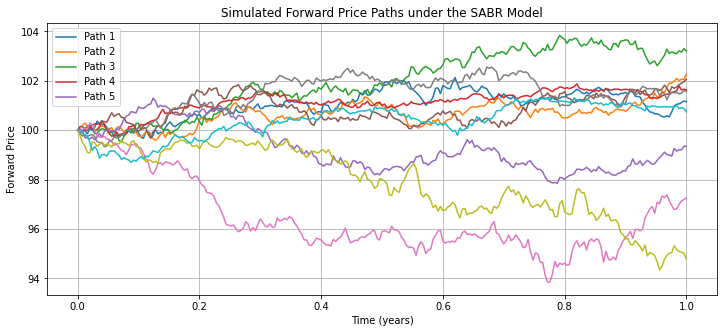

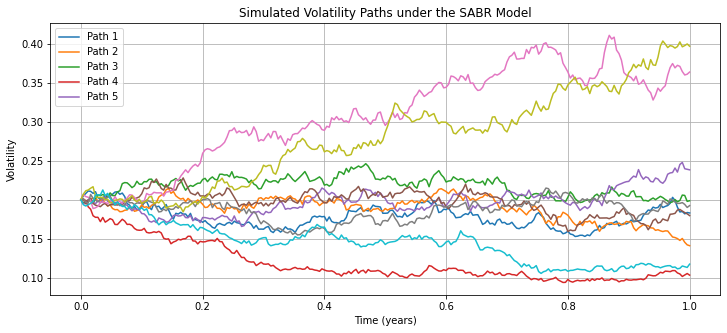

In [2]:
def simulate_sabr_paths(F0, alpha, beta, nu, rho, T, N, n_paths):
    """
    Simulate paths for the SABR model using the Euler-Maruyama method.

    Parameters:
    - F0: initial forward price
    - alpha: initial volatility (σ₀)
    - beta: elasticity parameter of the forward process
    - nu: volatility of volatility
    - rho: correlation between the two Brownian motions
    - T: time horizon
    - N: number of time steps
    - n_paths: number of simulation paths

    Outputs : 
    - times: array of time points
    - F_paths: simulated paths for the forward price (shape: n_paths x (N+1))
    - sigma_paths: simulated paths for the volatility (shape: n_paths x (N+1))
    """
    dt = T / N
    times = np.linspace(0, T, N + 1)
    
    # Initialize arrays for forward price and volatility
    F_paths = np.zeros((n_paths, N + 1))
    sigma_paths = np.zeros((n_paths, N + 1))
    
    F_paths[:, 0] = F0
    sigma_paths[:, 0] = alpha  # initial volatility
    
    for i in range(N):
        # Generate correlated Brownian increments
        dW = np.random.normal(scale=np.sqrt(dt), size=n_paths)
        dZ = rho * dW + np.sqrt(1 - rho**2) * np.random.normal(scale=np.sqrt(dt), size=n_paths)
        
        # Update forward price F using: dF = σ * F^β * dW
        F_paths[:, i + 1] = F_paths[:, i] + sigma_paths[:, i] * (F_paths[:, i] ** beta) * dW
        
        # Update volatility σ using: dσ = ν * σ * dZ
        sigma_paths[:, i + 1] = sigma_paths[:, i] + nu * sigma_paths[:, i] * dZ
    
    return times, F_paths, sigma_paths

# Set parameters
F0 = 100         # initial forward price
alpha = 0.2      # initial volatility level
beta = 0.5       # elasticity parameter
nu = 0.3         # volatility of volatility
rho = -0.4       # correlation between asset and volatility
T = 1.0          # time horizon (1 year)
N = 250          # number of time steps (daily steps for a year)
n_paths = 10     # number of simulation paths

# Simulate paths
times, F_paths, sigma_paths = simulate_sabr_paths(F0, alpha, beta, nu, rho, T, N, n_paths)

# Plot the simulated forward price paths
plt.figure(figsize=(12, 5))
for i in range(n_paths):
    plt.plot(times, F_paths[i], lw=1.5, label=f'Path {i+1}' if i < 5 else None)  # show label for first few paths
plt.title('Simulated Forward Price Paths under the SABR Model')
plt.xlabel('Time (years)')
plt.ylabel('Forward Price')
plt.grid(True)
plt.legend()
plt.show()

# Plot the simulated volatility paths
plt.figure(figsize=(12, 5))
for i in range(n_paths):
    plt.plot(times, sigma_paths[i], lw=1.5, label=f'Path {i+1}' if i < 5 else None)
plt.title('Simulated Volatility Paths under the SABR Model')
plt.xlabel('Time (years)')
plt.ylabel('Volatility')
plt.grid(True)
plt.legend()
plt.show()


<a id='2.1' > </a>
## <u>2.1 Influence of parameters

We can plot side by side the bound values of Beta and see that we find a normal process for $\beta = 0$ and a lognormal when $\beta = 1 $

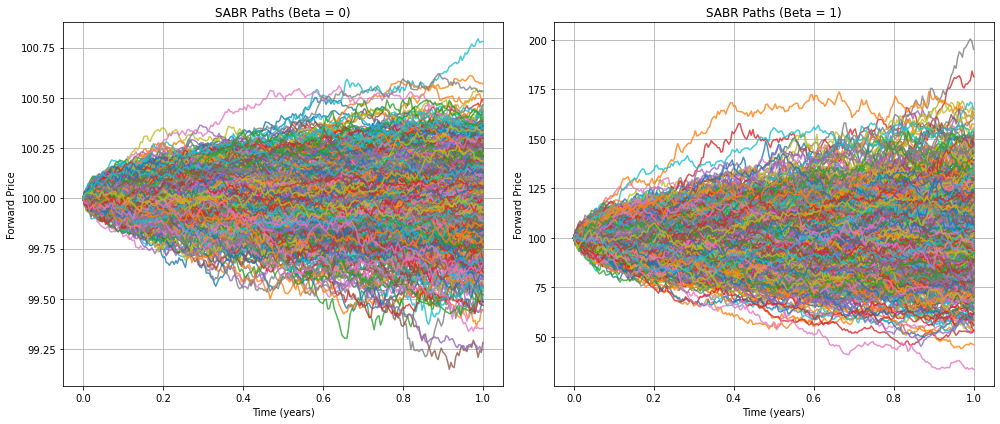

In [3]:
beta_values = [0, 1]
alpha = 0.2     # initial volatility level
nu = 0.3        # volatility of volatility
rho = -0.4      # correlation
n_paths = 1000

plt.figure(figsize=(14, 6))
for j, beta in enumerate(beta_values):
    times, F_paths, sigma_paths = simulate_sabr_paths(F0, alpha, beta, nu, rho, T, N, n_paths)
    plt.subplot(1, 2, j+1)
    for i in range(n_paths):
        plt.plot(times, F_paths[i], lw=1.5, alpha=0.8)
    plt.title(f'SABR Paths (Beta = {beta})')
    plt.xlabel('Time (years)')
    plt.ylabel('Forward Price')
    plt.grid(True)
plt.tight_layout()
plt.show()

We can then plot for different values of $\rho$. We can see that when $\rho = 0$, we get back some Black-Scholes class of model where the volatility is untied to the Forward price

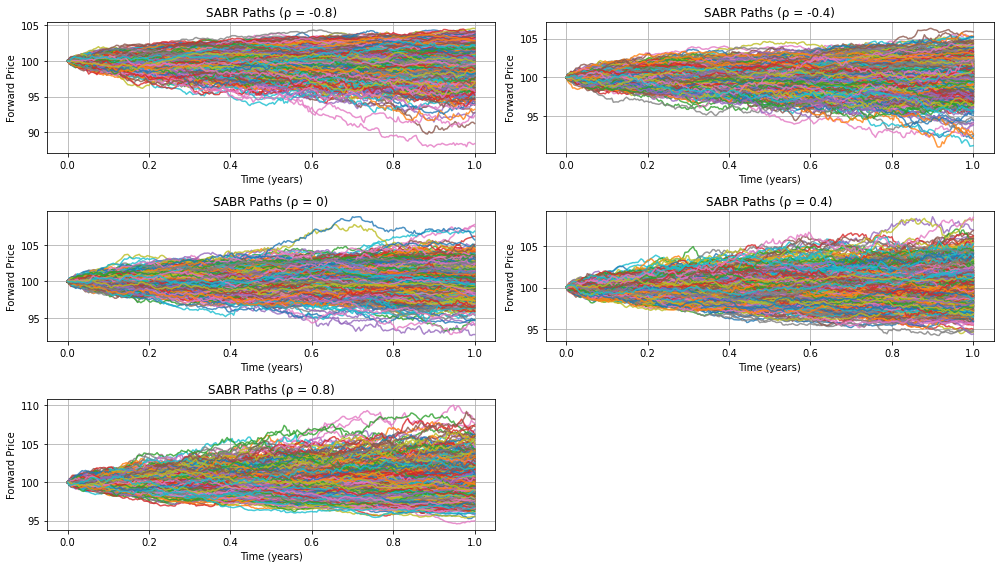

In [4]:
rho_values = [-0.8, -0.4, 0, 0.4, 0.8]
beta = 0.5      # fix beta to an intermediate value

plt.figure(figsize=(14, 8))
for idx, rho in enumerate(rho_values):
    times, F_paths, sigma_paths = simulate_sabr_paths(F0, alpha, beta, nu, rho, T, N, n_paths)
    plt.subplot(3, 2, idx+1)
    for i in range(n_paths):
        plt.plot(times, F_paths[i], lw=1.5, alpha=0.8)
    plt.title(f'SABR Paths (ρ = {rho})')
    plt.xlabel('Time (years)')
    plt.ylabel('Forward Price')
    plt.grid(True)
plt.tight_layout()
plt.show()

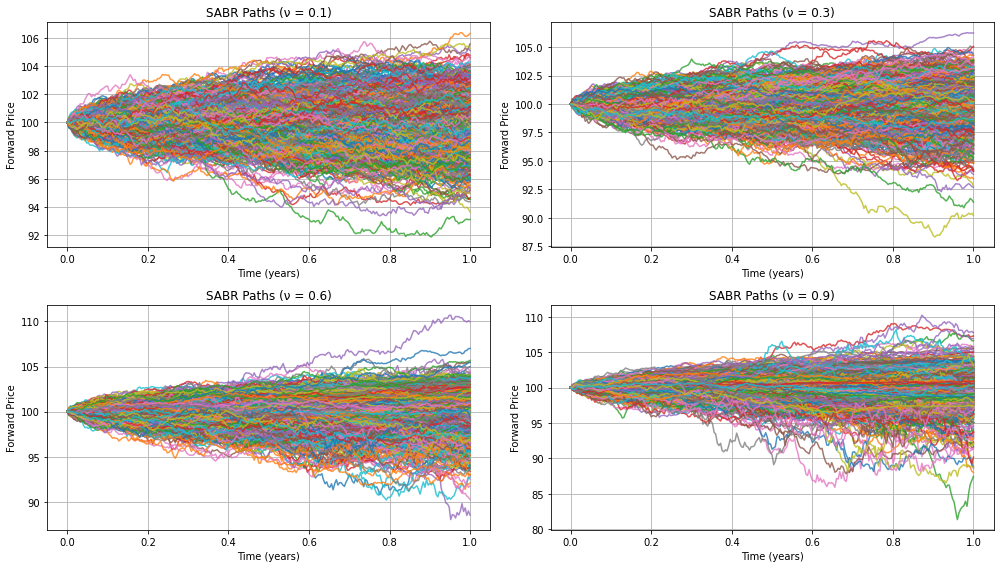

In [5]:
nu_values = [0.1, 0.3, 0.6, 0.9]
rho = -0.4     # fix rho
beta = 0.5     # fix beta

plt.figure(figsize=(14, 8))
for idx, nu_val in enumerate(nu_values):
    times, F_paths, sigma_paths = simulate_sabr_paths(F0, alpha, beta, nu_val, rho, T, N, n_paths)
    plt.subplot(2, 2, idx+1)
    for i in range(n_paths):
        plt.plot(times, F_paths[i], lw=1.5, alpha=0.8)
    plt.title(f'SABR Paths (ν = {nu_val})')
    plt.xlabel('Time (years)')
    plt.ylabel('Forward Price')
    plt.grid(True)
plt.tight_layout()
plt.show()

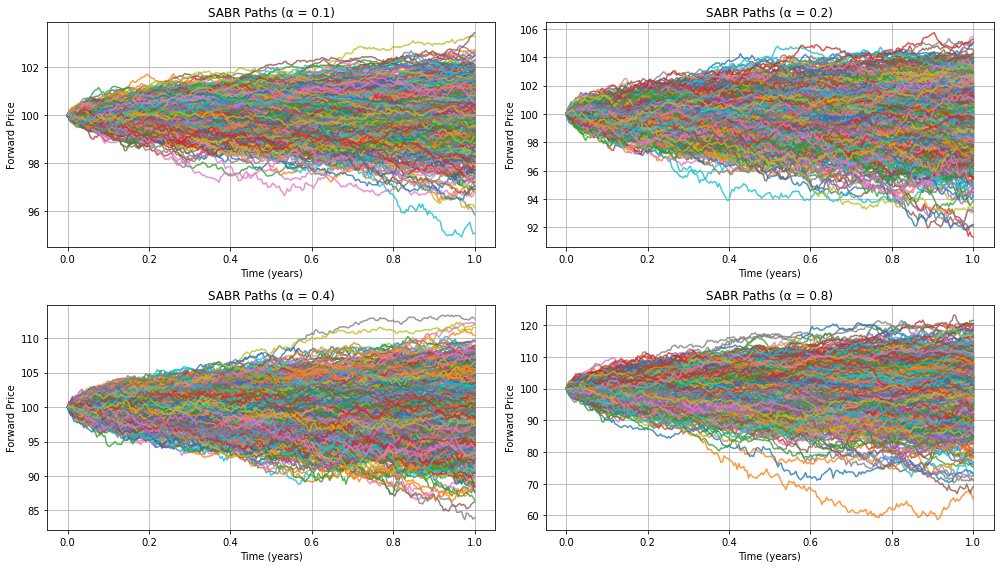

In [6]:
alpha_values = [0.1, 0.2, 0.4, 0.8]
rho = -0.4     # fix rho
beta = 0.5     # fix beta
nu = 0.3       # fix nu

plt.figure(figsize=(14, 8))
for idx, alpha_val in enumerate(alpha_values):
    times, F_paths, sigma_paths = simulate_sabr_paths(F0, alpha_val, beta, nu, rho, T, N, n_paths)
    plt.subplot(2, 2, idx+1)
    for i in range(n_paths):
        plt.plot(times, F_paths[i], lw=1.5, alpha=0.8)
    plt.title(f'SABR Paths (α = {alpha_val})')
    plt.xlabel('Time (years)')
    plt.ylabel('Forward Price')
    plt.grid(True)
plt.tight_layout()
plt.show()

<a id='3' > </a>
# <u>3. Calibration on a specific maturity 

<a id='3.1' > </a>
## <u>3.1 Getting option data from yfinance

In [7]:
# Choose a ticker (e.g., SPY) and get its option chain data
ticker_symbol = 'SPY'
ticker = yf.Ticker(ticker_symbol)

# List available expiration dates
expirations = ticker.options
print("Available expiration dates:", expirations)

# Choose one expiration date (e.g., the 10th available)
expiration = expirations[10]
print("Chosen expiration :",expiration)
option_chain = ticker.option_chain(expiration)
calls = option_chain.calls

# Filter the calls DataFrame for the relevant columns.
# Note: sometimes the 'impliedVolatility' column is available.
market_data = calls[['strike', 'impliedVolatility']]
market_data = market_data[market_data['impliedVolatility'] > 0]  # filter out any zeros
market_data.sort_values('strike', inplace=True)

# Calculate time-to-maturity in years
today = datetime.today()
expiry_date = datetime.strptime(expiration, "%Y-%m-%d")
T = (expiry_date - today).days / 365.0
if T <= 0:
    T = 0.01  # fallback in case expiration is in the past
print(f"Time to maturity T = {T:.3f} years")

Available expiration dates: ('2025-02-18', '2025-02-19', '2025-02-20', '2025-02-21', '2025-02-24', '2025-02-25', '2025-02-26', '2025-02-27', '2025-02-28', '2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-03-31', '2025-04-04', '2025-04-17', '2025-04-30', '2025-05-16', '2025-05-30', '2025-06-20', '2025-06-30', '2025-07-18', '2025-07-31', '2025-08-15', '2025-09-19', '2025-09-30', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17')
Chosen expiration : 2025-03-14
Time to maturity T = 0.066 years


<a id='3.2' > </a>
## <u>3.2 Hagan's approximation of Implied Volatility

$$
\sigma_{\text{imp}}(K) = \frac{\alpha}{(F K)^{\frac{1-\beta}{2}}} \frac{z}{x(z)} \left\{ 1 + \left[ \frac{(1-\beta)^2}{24} \frac{\log^2\left(\frac{F}{K}\right)}{(F K)^{1-\beta}} + \frac{\rho \beta \nu\, \log\left(\frac{F}{K}\right)}{4 (F K)^{\frac{1-\beta}{2}}} + \frac{\nu^2 (2-3\rho^2)}{24} \right] T \right\},
$$

In [8]:
def sabr_vol(alpha, beta, rho, nu, F, K, T):
    """
    Computes the SABR implied volatility using Hagan's approximation.
    
    Parameters:
      alpha, beta, rho, nu : SABR parameters
      F : Forward (or spot) price
      K : Strike price
      T : Time-to-maturity (in years)
    """
    if F == K:
        # ATM formula
        term1 = alpha / (F**(1-beta))
        term2 = 1 + (((1-beta)**2/24)*(alpha**2)/(F**(2-2*beta)) + 
                     0.25*rho*beta*nu*alpha/(F**(1-beta)) +
                     (2-3*rho**2)/24*nu**2)*T
        return term1 * term2
    else:
        FK_beta = (F * K)**((1-beta)/2)
        log_FK = np.log(F/K)
        z = (nu/alpha) * FK_beta * log_FK
        
        # Avoid division by zero issues if z is small
        eps = 1e-07
        if abs(z) < eps:
            x_z = 1 - 0.5*rho*z + (1/6)*(rho**2 - 1)*z**2  # second-order expansion
        else:
            numerator = np.sqrt(1 - 2*rho*z + z**2) + z - rho
            denominator = 1 - rho
            x_z = np.log(numerator/denominator)
            
        term1 = alpha / (FK_beta)
        term2 = z/x_z
        term3 = 1 + (((1-beta)**2/24)*(log_FK**2) + 0.25*rho*beta*nu*log_FK +
                     (2-3*rho**2)/24*nu**2)*T
        return term1 * term2 * term3

<a id='3.3' > </a>
## <u>3.3 Mean Squared Error Calibration

In [9]:
# We fix beta (e.g., beta=0.5) and calibrate alpha, rho, and nu.
beta_fixed = 0.5

# Use the spot price as a proxy for the forward price
F = ticker.history(period="1d")['Close'].iloc[-1]
print(f"Underlying Spot Price (proxy for Forward): {F:.2f}")

# Extract market strikes and implied volatilities
strikes = market_data['strike'].values
market_vols = market_data['impliedVolatility'].values

# Define the objective function for calibration (sum of squared errors)
def objective(params):
    alpha, rho, nu = params
    model_vols = np.array([sabr_vol(alpha, beta_fixed, rho, nu, F, K, T) for K in strikes])
    return np.sum((model_vols - market_vols)**2)

# Initial guesses:
# - Use the ATM implied volatility (strike closest to F) for alpha.
atm_index = np.argmin(np.abs(strikes - F))
alpha_guess = market_vols[atm_index]
initial_guess = [alpha_guess, 0.0, 0.5]  # [alpha, rho, nu]

# Parameter bounds: alpha > 0, -1 < rho < 1, nu > 0
bounds = [(1e-4, None), (-0.999, 0.999), (1e-4, None)]

# Run the optimization
result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
alpha_cal, rho_cal, nu_cal = result.x

print("Calibrated SABR parameters:")
print(f"alpha: {alpha_cal:.4f}, beta: {beta_fixed:.4f}, rho: {rho_cal:.4f}, nu: {nu_cal:.4f}")

Underlying Spot Price (proxy for Forward): 609.70
Calibrated SABR parameters:
alpha: 3.1726, beta: 0.5000, rho: -0.8332, nu: 6.1922


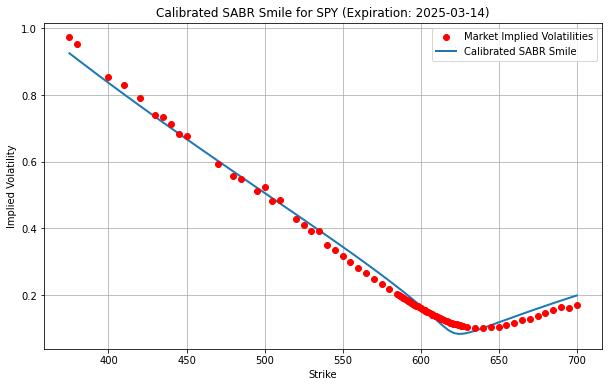

In [10]:
# Create a smooth range of strikes for plotting the SABR smile
strike_range = np.linspace(min(strikes), max(strikes), 100)
model_vols_range = np.array([sabr_vol(alpha_cal, beta_fixed, rho_cal, nu_cal, F, K, T) for K in strike_range])

plt.figure(figsize=(10,6))
plt.scatter(strikes, market_vols, color='red', label='Market Implied Volatilities', zorder=5)
plt.plot(strike_range, model_vols_range, label='Calibrated SABR Smile', lw=2)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'Calibrated SABR Smile for {ticker_symbol} (Expiration: {expiration})')
plt.legend()
plt.grid(True)
plt.show()

<a id='4' > </a>
# <u>4. Surface Calibration

<a id='4.1' > </a>
## <u>4.1 Data retreival from yfinance

In [11]:
def get_option_data(ticker_symbol, num_exp, implied_vol_threshold=0.005):
    """
    Retrieve option market data from yfinance for the last X expirations.
    
    Parameters:
      ticker_symbol (str): The ticker symbol (e.g., 'SPY')
      num_exp (int): Number of expirations to retrieve (from the available expirations)
      implied_vol_threshold (float): Minimum implied volatility to filter out near-zero vols
    
    Returns:
      DataFrame: Contains columns 'strike', 'market_vol', 'T', and 'exp_date'
                 where T is the time-to-maturity in years.
    """
    ticker = yf.Ticker(ticker_symbol)
    
    # Use the last num_exp expirations (assumes the list is ordered chronologically)
    expirations = ticker.options[-num_exp:]
    print("Using expirations:", expirations)
    
    # Get the underlying spot price (used as proxy for F)
    hist = ticker.history(period="1d")
    if hist.empty:
        raise ValueError("No historical data found for ticker.")
    spot_price = hist['Close'].iloc[-1]
    print(f"Underlying spot price: {spot_price:.2f}")
    
    data_points = []
    today = datetime.today()
    
    # Loop over each expiration to extract strikes, implied vols, T, and expiration date
    for exp in expirations:
        try:
            option_chain = ticker.option_chain(exp)
        except Exception as e:
            print(f"Error retrieving expiration {exp}: {e}")
            continue
        
        calls = option_chain.calls
        # Filter out rows with near-zero implied vols and non-positive strikes
        calls = calls[(calls['impliedVolatility'] > implied_vol_threshold) & (calls['strike'] > 0)]
        if calls.empty:
            continue
        
        expiry_date = datetime.strptime(exp, "%Y-%m-%d")
        T = (expiry_date - today).days / 365.0
        if T <= 0:
            continue
        
        for _, row in calls.iterrows():
            data_points.append({
                'strike': row['strike'],
                'market_vol': row['impliedVolatility'],
                'T': T,
                'exp_date': exp
            })
    
    market_df = pd.DataFrame(data_points)
    print(f"Total number of data points: {len(market_df)}")
    return market_df, spot_price

<a id='4.2' > </a>
## <u>4.2 Global Calibration

The first instinct is to calibrate the model on the whole market data. But there are multiple problems with this approach : 

- There might be more points of data for certain maturities (certainly for shorter maturities). That will make the model fit more on certain maturities than others. We can remedy that problem by selecting the same amounts of points for every maturity, but then, what points to exclude ? 

- In market data, the data isn't smooth maturity point to maturity point. so the fit might be doomed to fail.

Using expirations: ('2025-09-19', '2025-09-30', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17')
Underlying spot price: 609.70
Total number of data points: 1228
Global calibrated SABR parameters:
alpha: 5.3963, beta (fixed): 0.5000, rho: -0.8437, nu: 1.2803
Unique expirations in the market data: ['2025-09-19' '2025-09-30' '2025-12-19' '2025-12-31' '2026-01-16'
 '2026-03-20' '2026-06-18' '2026-12-18' '2027-01-15' '2027-12-17']


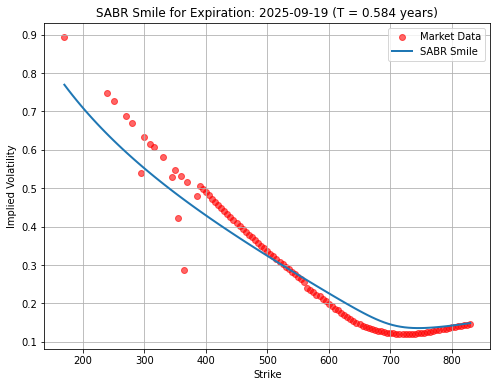

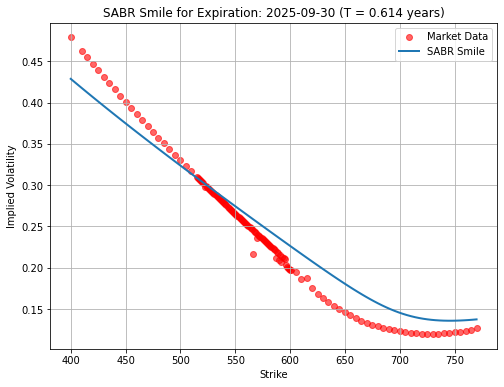

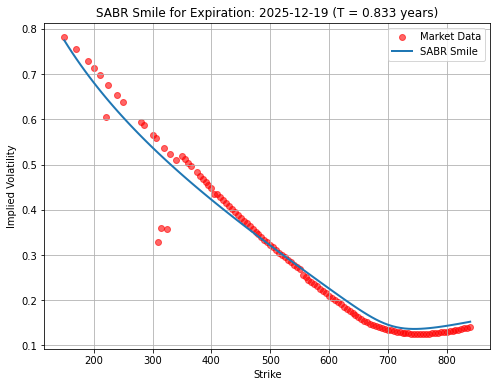

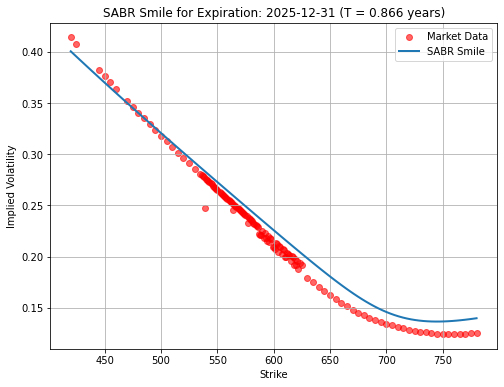

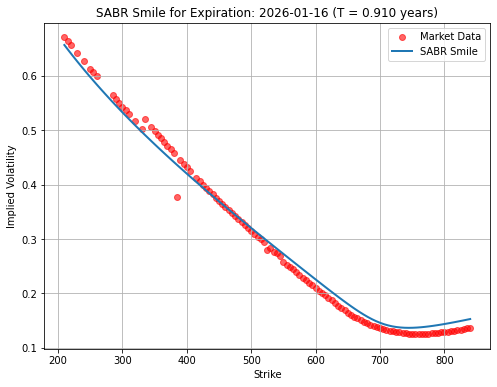

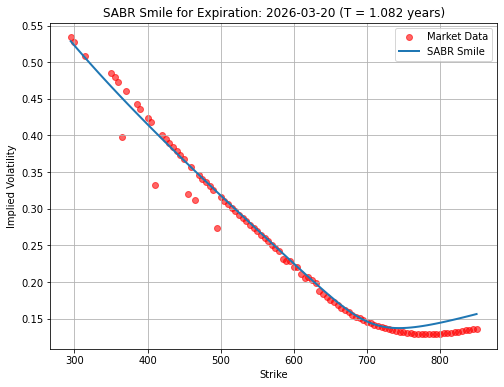

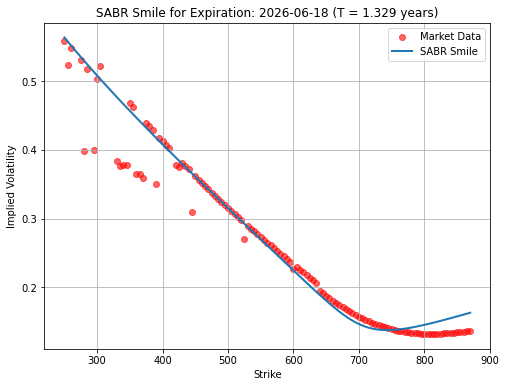

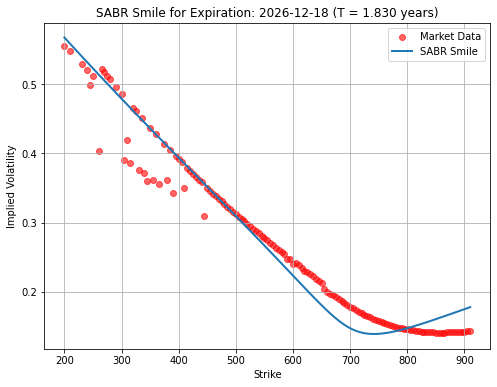

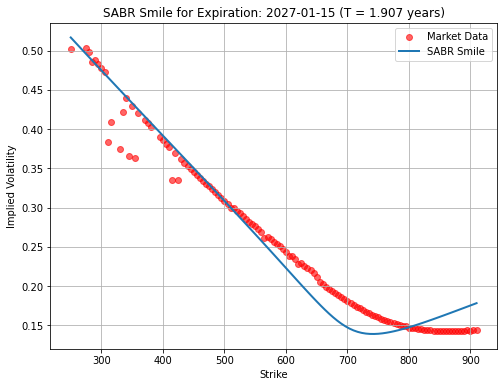

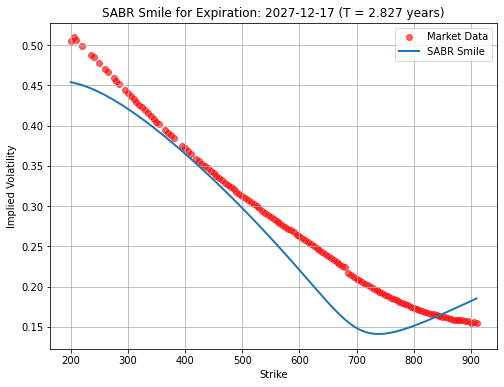

In [12]:
# Retrieve Market Data for Last X Expirations
num_exp = 10  # change this value as needed
market_df, spot_price = get_option_data('SPY', num_exp=num_exp)

# Global Calibration of SABR Parameters
beta_fixed = 0.5

def global_objective(params):
    alpha, rho, nu = params
    error = 0.0
    for idx, row in market_df.iterrows():
        K = row['strike']
        market_vol = row['market_vol']
        T = row['T']
        model_vol = sabr_vol(alpha, beta_fixed, rho, nu, spot_price, K, T)
        error += (model_vol - market_vol)**2
    return error

# Use the ATM point (strike closest to spot) to initialize alpha
atm_idx = (market_df['strike'] - spot_price).abs().idxmin()
alpha_guess = market_df.loc[atm_idx, 'market_vol']
initial_guess = [alpha_guess, 0.0, 0.5]  # [alpha, rho, nu]
bounds = [(1e-4, None), (-0.999, 0.999), (1e-4, None)]

result = minimize(global_objective, initial_guess, bounds=bounds, method='L-BFGS-B')
alpha_cal, rho_cal, nu_cal = result.x

print("Global calibrated SABR parameters:")
print(f"alpha: {alpha_cal:.4f}, beta (fixed): {beta_fixed:.4f}, rho: {rho_cal:.4f}, nu: {nu_cal:.4f}")


# Plot Maturity-by-Maturity ----------------------------------
unique_exp = market_df['exp_date'].unique()
print("Unique expirations in the market data:", unique_exp)

for exp in unique_exp:
    df_exp = market_df[market_df['exp_date'] == exp]
    strikes_exp = df_exp['strike'].values
    market_vols_exp = df_exp['market_vol'].values
    # Use the T from the first row (they should all be nearly identical for a given expiration)
    T_val = df_exp['T'].iloc[0]
    
    # Create a smooth strike grid for plotting the SABR smile
    strike_grid = np.linspace(min(strikes_exp), max(strikes_exp), 100)
    model_vols_grid = np.array([sabr_vol(alpha_cal, beta_fixed, rho_cal, nu_cal, spot_price, K, T_val) 
                                for K in strike_grid])
    
    plt.figure(figsize=(8, 6))
    plt.scatter(strikes_exp, market_vols_exp, label="Market Data", color='red', alpha=0.6)
    plt.plot(strike_grid, model_vols_grid, lw=2, label="SABR Smile")
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.title(f"SABR Smile for Expiration: {exp} (T = {T_val:.3f} years)")
    plt.legend()
    plt.grid(True)
    plt.show()


<a id='4.3' > </a>
## <u>4.3 Maturity-by-maturity Calibration 

Maturity by maturity calibiration makes for better fit results but the obvious drawback is that we don't get a proper SABR implied volatility surface, but rather a bunch of curves for each maturity.

Using expirations: ('2025-09-19', '2025-09-30', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17')
Underlying spot price: 609.70
Total number of data points: 1228
Unique expirations in the market data: ['2025-09-19' '2025-09-30' '2025-12-19' '2025-12-31' '2026-01-16'
 '2026-03-20' '2026-06-18' '2026-12-18' '2027-01-15' '2027-12-17']
Expiration: 2025-09-19 (T = 0.584 years)
   Calibrated parameters: alpha = 4.9644, rho = -0.8840, nu = 1.8474


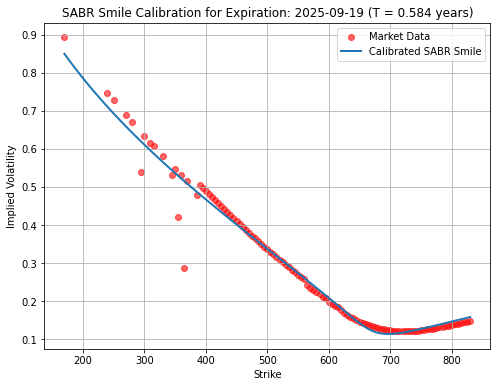

Expiration: 2025-09-30 (T = 0.614 years)
   Calibrated parameters: alpha = 4.7757, rho = -0.8622, nu = 1.8656


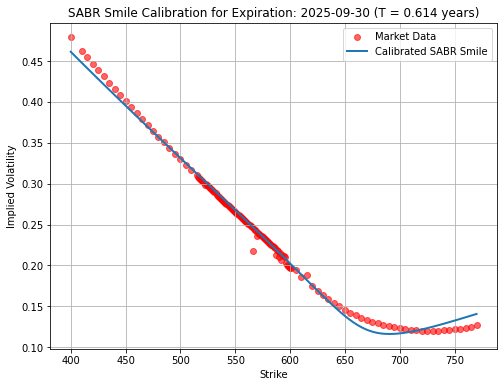

Expiration: 2025-12-19 (T = 0.833 years)
   Calibrated parameters: alpha = 5.2481, rho = -0.8790, nu = 1.4311


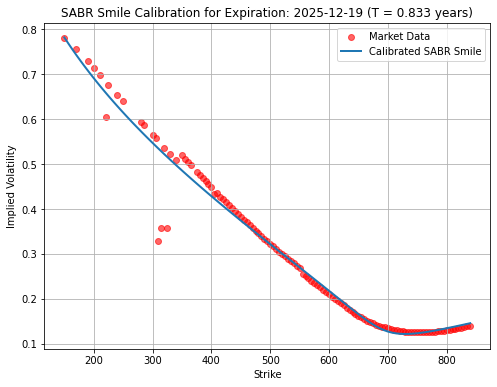

Expiration: 2025-12-31 (T = 0.866 years)
   Calibrated parameters: alpha = 5.1180, rho = -0.8604, nu = 1.4455


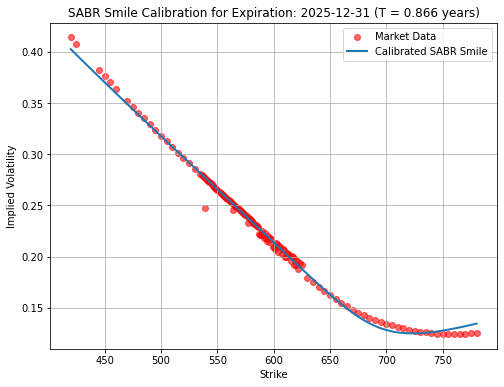

Expiration: 2026-01-16 (T = 0.910 years)
   Calibrated parameters: alpha = 5.1899, rho = -0.8747, nu = 1.4650


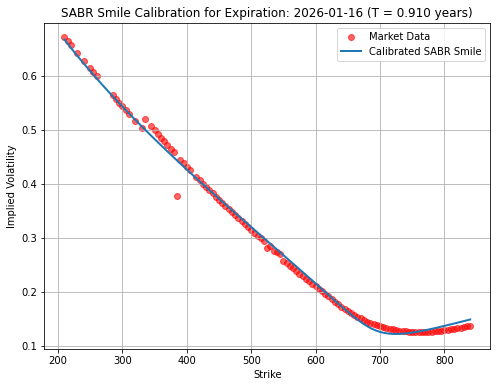

Expiration: 2026-03-20 (T = 1.082 years)
   Calibrated parameters: alpha = 5.4323, rho = -0.8751, nu = 1.2577


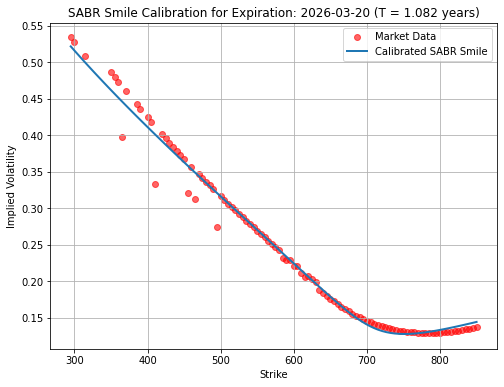

Expiration: 2026-06-18 (T = 1.329 years)
   Calibrated parameters: alpha = 5.6477, rho = -0.8808, nu = 0.9789


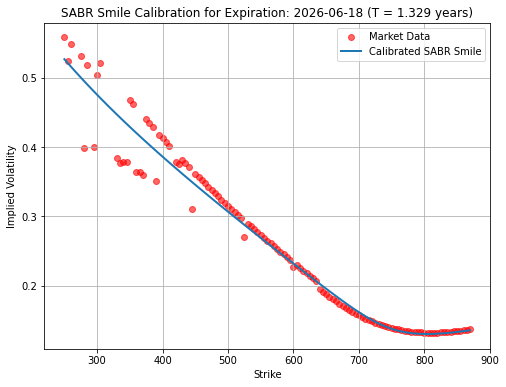

Expiration: 2026-12-18 (T = 1.830 years)
   Calibrated parameters: alpha = 5.9335, rho = -0.8714, nu = 0.8588


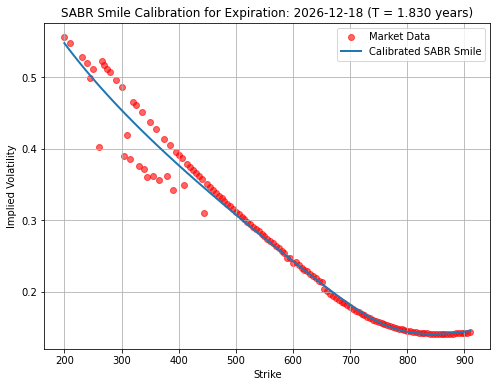

Expiration: 2027-01-15 (T = 1.907 years)
   Calibrated parameters: alpha = 5.9486, rho = -0.8664, nu = 0.8695


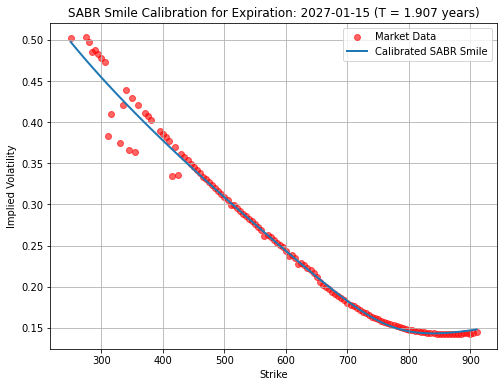

Expiration: 2027-12-17 (T = 2.827 years)
   Calibrated parameters: alpha = 6.4254, rho = -0.8534, nu = 0.7544


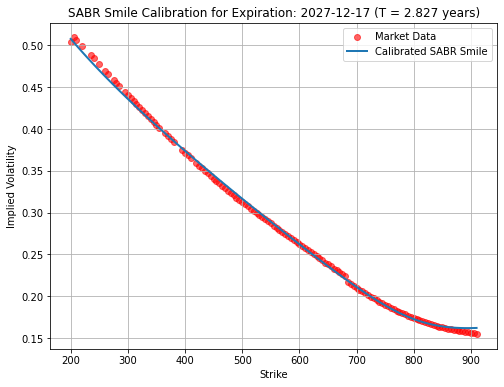

In [13]:
# Retrieve Market Data for Last X Expirations
num_exp = 10  # change this value as needed
market_df, spot_price = get_option_data('SPY', num_exp=num_exp)

# Global Calibration of SABR Parameters
beta_fixed = 0.5

# Get unique expiration dates from the data.
unique_exp = market_df['exp_date'].unique()
print("Unique expirations in the market data:", unique_exp)

for exp in unique_exp:
    # Extract market data for the current expiration.
    df_exp = market_df[market_df['exp_date'] == exp]
    strikes_exp = df_exp['strike'].values
    market_vols_exp = df_exp['market_vol'].values
    # Use the T from the first row (all points for an expiration should have nearly identical T).
    T_val = df_exp['T'].iloc[0]
    
    # Define the objective function for this expiration.
    def objective(params):
        alpha, rho, nu = params
        error = 0.0
        for strike, mkt_vol in zip(strikes_exp, market_vols_exp):
            model_vol = sabr_vol(alpha, beta_fixed, rho, nu, spot_price, strike, T_val)
            error += (model_vol - mkt_vol)**2
        return error
    
    # Use the ATM point (strike closest to spot) to initialize alpha.
    atm_idx = np.argmin(np.abs(strikes_exp - spot_price))
    alpha_guess = market_vols_exp[atm_idx]
    initial_guess = [alpha_guess, 0.0, 0.5]  # [alpha, rho, nu]
    bounds = [(1e-4, None), (-0.999, 0.999), (1e-4, None)]
    
    # Optimize the parameters for this expiration.
    res = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    alpha_cal, rho_cal, nu_cal = res.x
    
    print(f"Expiration: {exp} (T = {T_val:.3f} years)")
    print(f"   Calibrated parameters: alpha = {alpha_cal:.4f}, rho = {rho_cal:.4f}, nu = {nu_cal:.4f}")
    
    # Create a smooth strike grid for plotting.
    strike_grid = np.linspace(min(strikes_exp), max(strikes_exp), 100)
    model_vols_grid = np.array([sabr_vol(alpha_cal, beta_fixed, rho_cal, nu_cal, spot_price, K, T_val)
                                 for K in strike_grid])
    
    # Plot the market data and the calibrated SABR smile.
    plt.figure(figsize=(8, 6))
    plt.scatter(strikes_exp, market_vols_exp, label="Market Data", color='red', alpha=0.6)
    plt.plot(strike_grid, model_vols_grid, label="Calibrated SABR Smile", lw=2)
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.title(f"SABR Smile Calibration for Expiration: {exp} (T = {T_val:.3f} years)")
    plt.legend()
    plt.grid(True)
    plt.show()

<a id='5' > </a>
# <u>5. Example use : Implied Density of the terminal stock price

<a id='5.1' > </a>
## <u>5.1 using a global fit

Using expirations: ('2025-02-18', '2025-02-19', '2025-02-20', '2025-02-21', '2025-02-24', '2025-02-25', '2025-02-26', '2025-02-27', '2025-02-28', '2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-03-31', '2025-04-04', '2025-04-17', '2025-04-30', '2025-05-16', '2025-05-30', '2025-06-20', '2025-06-30', '2025-07-18', '2025-07-31', '2025-08-15', '2025-09-19', '2025-09-30', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17')
Underlying spot price: 609.70
Total number of data points: 3470
Global calibrated SABR parameters:
alpha: 4.8165, beta (fixed): 0.5000, rho: -0.8465, nu: 3.0657


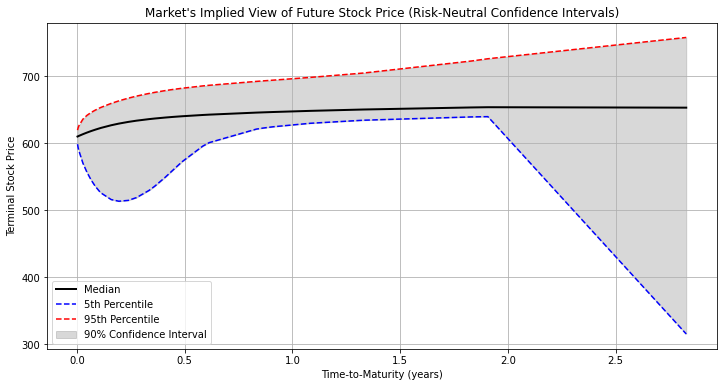

In [14]:
# Global Calibration on First Maturities --------------------
num_exp = 40  # Use the first num_exp expirations
market_df, spot_price = get_option_data('SPY', num_exp=num_exp)
beta_fixed = 0.5

# Initialize using the ATM point from all data (strike closest to spot)
atm_idx = (market_df['strike'] - spot_price).abs().idxmin()
alpha_guess = market_df.loc[atm_idx, 'market_vol']
initial_guess = [alpha_guess, 0.0, 0.5]  # [alpha, rho, nu]
bounds = [(1e-4, None), (-0.999, 0.999), (1e-4, None)]

result = minimize(global_objective, initial_guess, bounds=bounds, method='L-BFGS-B')
alpha_cal, rho_cal, nu_cal = result.x

print("Global calibrated SABR parameters:")
print(f"alpha: {alpha_cal:.4f}, beta (fixed): {beta_fixed:.4f}, rho: {rho_cal:.4f}, nu: {nu_cal:.4f}")

# Package the calibrated parameters
sabr_params = (alpha_cal, beta_fixed, rho_cal, nu_cal)


# Compute Implied Densities and Extract Percentiles for Each Maturity --------------------

# Get unique expirations sorted by time-to-maturity (T)
df_by_exp = market_df.groupby('exp_date').first().reset_index()  # one row per expiration
df_by_exp = df_by_exp.sort_values('T')
unique_exp = df_by_exp['exp_date'].values
T_vals = df_by_exp['T'].values

# Prepare arrays to store percentiles
p5_list = []
p50_list = []
p95_list = []
T_list = []  # corresponding time-to-maturity values

# Define a strike grid for density calculations (choose a wide grid around spot_price)
strike_grid = np.linspace(0.5 * spot_price, 1.5 * spot_price, 300)
dK = strike_grid[1] - strike_grid[0]

for exp in unique_exp:
    # Get the T for this expiration (they should all be nearly identical for a given expiration)
    T_val = market_df[market_df['exp_date'] == exp]['T'].iloc[0]
    T_list.append(T_val)
    
    # Compute call prices on the strike grid using the SABR-implied volatility and Black formula.
    call_prices = []
    for K in strike_grid:
        sigma_imp = sabr_vol(alpha_cal, beta_fixed, rho_cal, nu_cal, spot_price, K, T_val)
        # Use Black's formula with r=0 (for simplicity)
        if T_val > 0 and sigma_imp > 0:
            d1 = (np.log(spot_price/K) + 0.5 * sigma_imp**2 * T_val) / (sigma_imp * np.sqrt(T_val))
            d2 = d1 - sigma_imp * np.sqrt(T_val)
            price = spot_price * norm.cdf(d1) - K * norm.cdf(d2)
        else:
            price = max(spot_price - K, 0)
        call_prices.append(price)
    call_prices = np.array(call_prices)
    
    # Compute the risk-neutral density f(K) via finite differences: f(K) ~ d²C/dK².
    density = np.zeros_like(call_prices)
    density[1:-1] = (call_prices[:-2] - 2*call_prices[1:-1] + call_prices[2:]) / dK**2
    # For endpoints, use one-sided differences
    density[0] = (call_prices[0] - 2*call_prices[1] + call_prices[2]) / dK**2
    density[-1] = (call_prices[-3] - 2*call_prices[-2] + call_prices[-1]) / dK**2
    
    # Compute the cumulative distribution function (CDF) via cumulative trapezoidal integration.
    cdf = cumtrapz(density, strike_grid, initial=0)
    # Normalize the CDF (it might not sum exactly to 1 due to finite differences)
    cdf = cdf / cdf[-1]
    
    # Extract percentiles using interpolation.
    p5 = np.interp(0.05, cdf, strike_grid)
    p50 = np.interp(0.50, cdf, strike_grid)
    p95 = np.interp(0.95, cdf, strike_grid)
    
    p5_list.append(p5)
    p50_list.append(p50)
    p95_list.append(p95)

# Plotting ------------

plt.figure(figsize=(12, 6))
plt.plot(T_list, p50_list, 'k-', lw=2, label='Median')
plt.plot(T_list, p5_list, 'b--', lw=1.5, label='5th Percentile')
plt.plot(T_list, p95_list, 'r--', lw=1.5, label='95th Percentile')
plt.fill_between(T_list, p5_list, p95_list, color='gray', alpha=0.3, label='90% Confidence Interval')

plt.xlabel("Time-to-Maturity (years)")
plt.ylabel("Terminal Stock Price")
plt.title("Market's Implied View of Future Stock Price (Risk-Neutral Confidence Intervals)")
plt.legend()
plt.grid(True)
plt.show()


<a id='5.2' > </a>
## <u>5.2 using a Maturity by maturity fit

In [15]:
def black_call_price(F, K, T, sigma):
    """
    Compute the Black call option price with zero interest rate.
    """
    if T <= 0 or sigma <= 0:
        return max(F - K, 0)
    d1 = (np.log(F/K) + 0.5*sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return F*norm.cdf(d1) - K*norm.cdf(d2)

Using expirations: ('2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-03-31', '2025-04-04', '2025-04-17', '2025-04-30', '2025-05-16', '2025-05-30', '2025-06-20', '2025-06-30', '2025-07-18', '2025-07-31', '2025-08-15', '2025-09-19', '2025-09-30', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17')
Underlying spot price: 609.70
Total number of data points: 3023
Unique expirations for calibration: ['2025-03-07' '2025-03-14' '2025-03-21' '2025-03-28' '2025-03-31'
 '2025-04-17' '2025-04-30' '2025-05-16' '2025-05-30' '2025-06-20'
 '2025-06-30' '2025-07-18' '2025-07-31' '2025-08-15' '2025-09-19'
 '2025-09-30' '2025-12-19' '2025-12-31' '2026-01-16' '2026-03-20'
 '2026-06-18' '2026-12-18' '2027-01-15' '2027-12-17']
Exp: 2025-03-07 (T = 0.047 yrs) -> alpha: 2.9484, rho: -0.8299, nu: 7.4239
Exp: 2025-03-14 (T = 0.066 yrs) -> alpha: 3.1726, rho: -0.8332, nu: 6.1922
Exp: 2025-03-21 (T = 0.085 yrs) -> alpha: 3.0352, rho: -0.8814

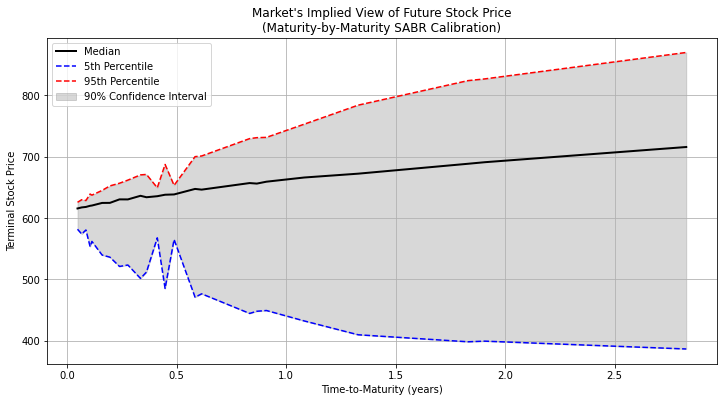

In [16]:
# Maturity-by-Maturity Calibration & Implied Density Extraction

num_exp = 25  # Use the first num_exp expirations
market_df, spot_price = get_option_data('SPY', num_exp=num_exp)

# We fix beta (e.g., 0.5) for each calibration.
beta_fixed = 0.5

# We'll store percentiles and corresponding time-to-maturity values.
p5_list = []
p50_list = []
p95_list = []
T_list = []
exp_dates = []

# For each unique expiration (group by exp_date)
unique_exp = np.sort(market_df['exp_date'].unique())
print("Unique expirations for calibration:", unique_exp)

# Define a common strike grid for density extraction (wide enough around spot)
strike_grid = np.linspace(0.5*spot_price, 1.5*spot_price, 300)
dK = strike_grid[1] - strike_grid[0]

for exp in unique_exp:
    df_exp = market_df[market_df['exp_date'] == exp]
    strikes_exp = df_exp['strike'].values
    market_vols_exp = df_exp['market_vol'].values
    # All points for an expiration should have nearly identical T; take T from first row.
    T_val = df_exp['T'].iloc[0]
    
    # Skip if T is too low
    if T_val <= 0:
        continue
    
    # ---------------------------
    # Calibrate SABR parameters for this expiration (slice-by-slice)
    # ---------------------------
    def objective(params):
        alpha, rho, nu = params
        error = 0.0
        for K, mkt_vol in zip(strikes_exp, market_vols_exp):
            model_vol = sabr_vol(alpha, beta_fixed, rho, nu, spot_price, K, T_val)
            error += (model_vol - mkt_vol)**2
        return error
    
    atm_idx = np.argmin(np.abs(strikes_exp - spot_price))
    alpha_guess = market_vols_exp[atm_idx]
    initial_guess = [alpha_guess, 0.0, 0.5]
    bounds = [(1e-4, None), (-0.999, 0.999), (1e-4, None)]
    
    res = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    alpha_cal, rho_cal, nu_cal = res.x
    print(f"Exp: {exp} (T = {T_val:.3f} yrs) -> alpha: {alpha_cal:.4f}, rho: {rho_cal:.4f}, nu: {nu_cal:.4f}")
    
    
    # Compute call prices on the strike grid using calibrated SABR
    call_prices = []
    for K in strike_grid:
        sigma_imp = sabr_vol(alpha_cal, beta_fixed, rho_cal, nu_cal, spot_price, K, T_val)
        price = black_call_price(spot_price, K, T_val, sigma_imp)
        call_prices.append(price)
    call_prices = np.array(call_prices)
    
    # Compute risk-neutral density via second derivative of call prices
    density = np.zeros_like(call_prices)
    density[1:-1] = (call_prices[:-2] - 2*call_prices[1:-1] + call_prices[2:]) / dK**2
    density[0] = (call_prices[0] - 2*call_prices[1] + call_prices[2]) / dK**2
    density[-1] = (call_prices[-3] - 2*call_prices[-2] + call_prices[-1]) / dK**2
    
    # Compute the cumulative distribution function (CDF) from the density
    cdf = cumtrapz(density, strike_grid, initial=0)
    cdf = cdf / cdf[-1]  # Normalize
    
    # Extract percentiles via interpolation on the CDF
    p5 = np.interp(0.05, cdf, strike_grid)
    p50 = np.interp(0.50, cdf, strike_grid)
    p95 = np.interp(0.95, cdf, strike_grid)
    
    p5_list.append(p5)
    p50_list.append(p50)
    p95_list.append(p95)
    T_list.append(T_val)
    exp_dates.append(exp)

# Plotting ------------
plt.figure(figsize=(12, 6))
plt.plot(T_list, p50_list, 'k-', lw=2, label='Median')
plt.plot(T_list, p5_list, 'b--', lw=1.5, label='5th Percentile')
plt.plot(T_list, p95_list, 'r--', lw=1.5, label='95th Percentile')
plt.fill_between(T_list, p5_list, p95_list, color='gray', alpha=0.3, label='90% Confidence Interval')
plt.xlabel("Time-to-Maturity (years)")
plt.ylabel("Terminal Stock Price")
plt.title("Market's Implied View of Future Stock Price\n(Maturity-by-Maturity SABR Calibration)")
plt.legend()
plt.grid(True)
plt.show()

<a id='6' > </a>
# <u>6. Conclusion

SABR belongs to the family of stochastic volatility models. Unlike simpler local volatility models, SABR incorporates random volatility dynamics (vol-of-vol) and a correlation parameter between the underlying asset and its volatility. This extra degree of freedom allows it to more accurately reflect the market's observed volatility structure. The SABR model has proven to be a powerful and flexible framework for capturing the dynamics of implied volatility surfaces. Some key takeaways from this exploration include:

- **Model Efficiency & Flexibility:**  

  The SABR model, through its stochastic volatility formulation, effectively captures the smile and skew phenomena observed in market-implied volatilities. While not perfect—especially at the extremes (e.g., very low strikes)—it provides a robust framework that is both computationally tractable (via Hagan's asymptotic approximation) and capable of adapting to various market conditions.
  

- **Practical Use & Calibration:**  


  - In practice, the SABR model is widely used in interest rate markets (e.g., for swaptions) and, increasingly, in equity and FX markets.  
  - A common industry practice is to calibrate the model slice-by-slice (i.e., for each maturity) rather than attempting a simultaneous global calibration. This acknowledges that the model parameters tend to vary with time-to-maturity.
  - While global calibration (as demonstrated) is useful for getting an overall sense of market dynamics, slice-by-slice calibration often yields a more accurate fit across different maturities.
  - Despite its strengths, the SABR model is not without limitations. The asymptotic approximations (such as Hagan's formula) may break down for extreme strikes or very volatile regimes, and calibration can be sensitive to market data quality.

Overall, the SABR model remains a valuable tool for practitioners. Its balance of theoretical rigor and practical applicability has led to its widespread adoption, particularly when used alongside other models and calibration techniques to ensure a comprehensive view of the volatility surface.
